# Lab 6: Inference and simulation

### Learning goals

- Understand the meaning and how to contstruct standard errors and confidence intervals.
- Understanding the idea of a sample distribution
- Bootstrapping
- Constructing standard errors and confidence intervals for proportions and comparisons
- Understanding what "Degrees of Freedom" means. 
- Understanding the role of the t-distribution
- Understanding the idea of statistical bias
- Hypothesis testing and statistical significance
- Understanding the idea of a p-value





### Literature
ROS Ch. 4 and 5

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as spt

from cycler import cycler

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams["axes.labelsize"]= 12
plt.rcParams["figure.facecolor"] = "#f2f2f2"
#plt.rcParams['figure.savefig.dpi'] = 100
plt.rcParams['savefig.edgecolor'] = "#f2f2f2"
plt.rcParams['savefig.facecolor'] ="#f2f2f2"
plt.rcParams["figure.figsize"] = [16,10]
plt.rcParams['savefig.bbox'] = "tight"
plt.rcParams['font.size'] = 14
greens = ['#66c2a4','#41ae76','#238b45','#006d2c','#00441b']
multi =['#66c2a4','#1f78b4','#a6cee3','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f']
plt.rcParams["axes.prop_cycle"] = cycler(color=multi)



### Standard Errors and Confidence intervalls

<iframe src="https://ntnu.cloud.panopto.eu/Panopto/Pages/Embed.aspx?id=14e9df4a-4bd2-4450-972c-af02009e1221&autoplay=false&offerviewer=true&showtitle=true&showbrand=true&captions=false&interactivity=all" height="405" width="720" style="border: 1px solid #464646;" allowfullscreen allow="autoplay"></iframe>

Let's start off by playing god. 

We, as almighty deities, decide that real GDP per person (expenditure side) across countries will be normally distributed with a mean of 50,000 USD and a standard deviation of 25,000. We can write this in notation as:

$rGDP \sim N(50, 25)$



We can easily create a sample of data - let's say for 100 countries

In [4]:
true_mean = 50
true_std = 10
S = 100

rGDP = pd.Series(np.random.normal(true_mean,true_std,S))

<AxesSubplot:>

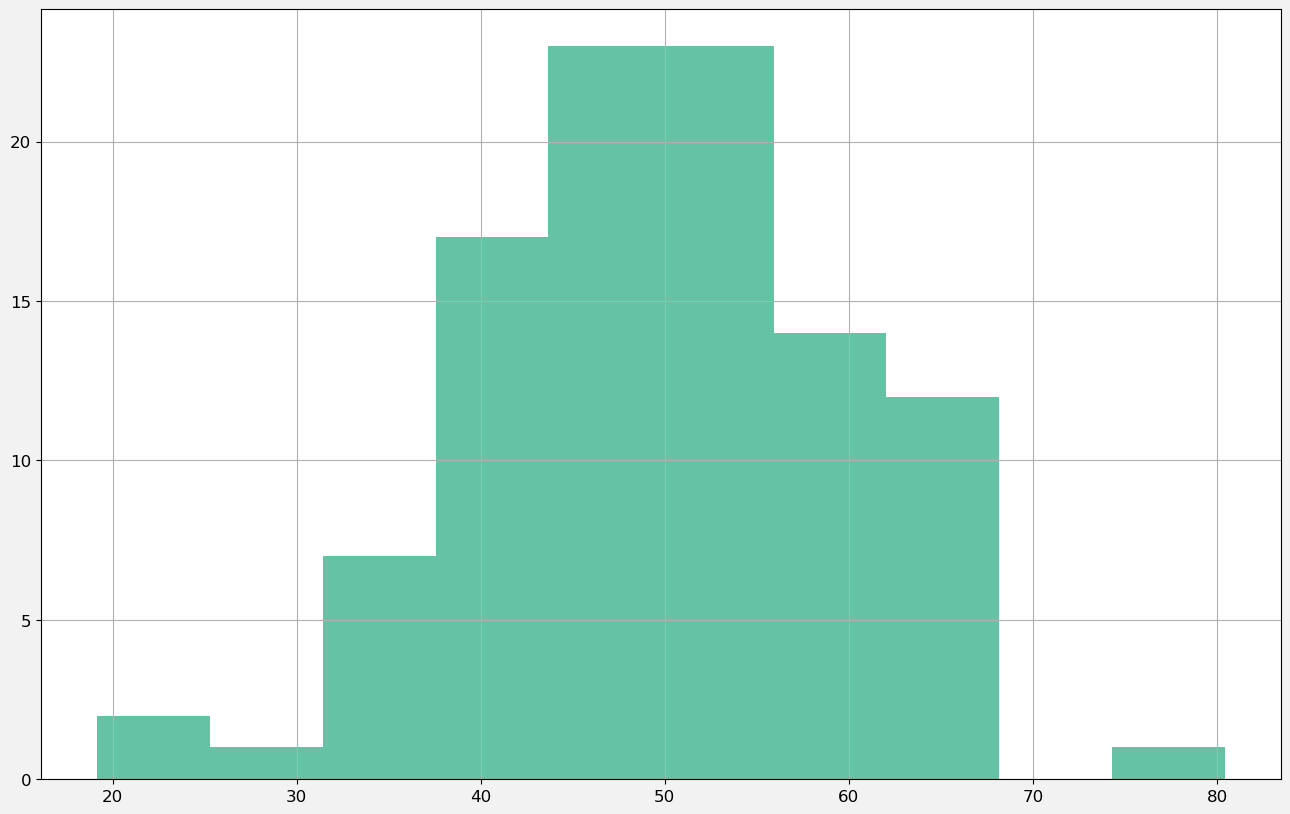

In [5]:
rGDP.hist()

We'll ignore the issue of potentially getting a negative value - which doesn't make sense -- we could relatively easily fix this by using the log-normal distribution and then transforming. 

Now we switch to being the humble statistician who wants to know what the mean real GDP is among the countries of the world. 

We would of course make a sample estimate by taking the average:

In [6]:
mean_estimate = rGDP.mean()
print("estimate of mean", mean_estimate)

estimate of mean 49.62514555904474


And we could esimate the sample standard deviation as well: 

In [7]:
std_estimate = rGDP.std(ddof=1)
print("estimate of std", std_estimate)

estimate of std 10.537610374255628


(We will explain the "ddf=1" a bit later)

#### Standard Error and estimating uncertainty

But how certain is the statistician that this number actually is close to the "true" mean?

Again switching to god-mode, we could have generated many--say 10000--different sets of 100 draws from our "true" distribution, and then see the amount of variation there is of the means. We could easily simulate this:

In [8]:
N = 10000
sampleMeans = []

for i in range(N):
    sample = np.random.normal(true_mean, true_std, S)
    sampleMeans.append(sample.mean())



<AxesSubplot:>

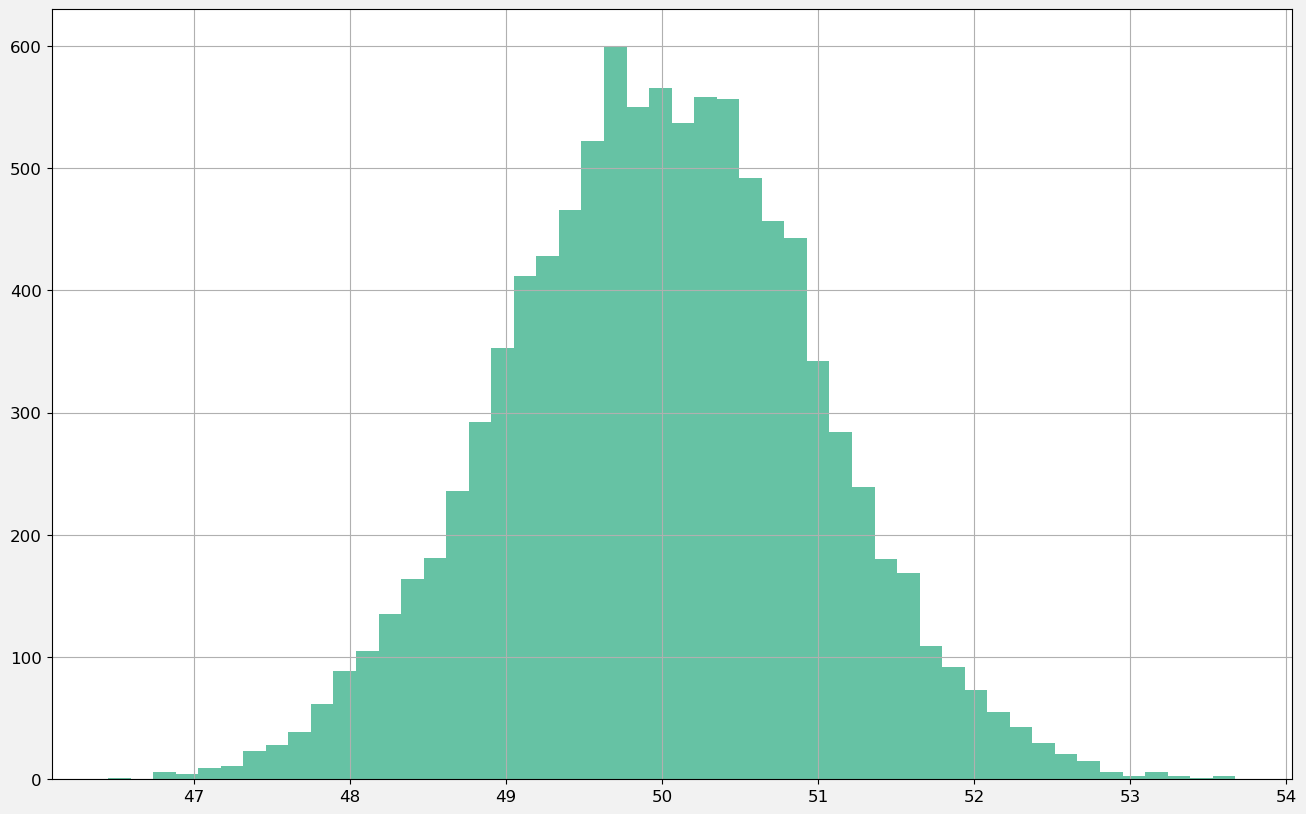

In [9]:
sampleMeans = pd.Series(sampleMeans)
sampleMeans.hist(bins=50)
                

Now we can calculate the standard deviation of all these sample means:

In [22]:
SE1 = sampleMeans.std()
print(SE1)

1.003584347051848


The standard deviation of the sample estimate - you should get close to 1 - is what we call the **standard error**. It gives us information about how uncertain the sample estimate (in this case of our mean) is. 

Of course, we don't have access to the actual "True" mean and "True" standard deviation of the sample in most real-life cases, so we could instead run the simulation based on the initial sample estimates: 

In [23]:
N = 10000
sampleMeans = []

for i in range(N):
    sample = np.random.normal(mean_estimate, std_estimate, S)
    sampleMeans.append(sample.mean())




In [24]:
sampleMeans =  pd.Series(sampleMeans)
SE2 =sampleMeans.std()
print(SE2)

1.0371844666218777


Not much difference!

If you recall from lab 5, around 68% percent of the estimates ("probability mass") should lie between +/- 1 **standard errors** of the sample mean. 

This is what we call a **Confidence Interval**

We can confirm this by estimating the share of sample means between +/1 standard errors of our sample mean:

In [25]:
CI_neg = mean_estimate - 1*SE2
CI_pos = mean_estimate + 1*SE2
print("Confidence Interval between:", CI_neg, CI_pos)

Confidence Interval between: 49.13957877134323 51.21394770458699


In [26]:
sampleMeans[(sampleMeans>CI_neg)&(sampleMeans<CI_pos)].count()/sampleMeans.count()

0.683

Pretty close!

Depending on our viewpoint, we could interpret the confidence interval in several ways: 

Thomas might say: "We are about 68% sure that the mean lies between these two numbers"

or 

Ronald might say "In 68% of samples the mean will lie between these two numbers


(More about this distinction later when we discuss Bayesian Theory, but just use whatever is most intuitive for a given situation)

Now let's say that 68% doesn't quite do it. Let's try a confidence interval of 2 standard errors.

In [27]:
CI_neg = mean_estimate - 2*SE2
CI_pos = mean_estimate + 2*SE2
print("Confidence Interval between:", CI_neg, CI_pos)

Confidence Interval between: 48.10239430472136 52.251132171208866


If you recall from lab 5, 2 standard deviations (or standard errors as we will call them here) in either direction of the mean for a normal distribution should cover about 95% of the estimates in our distribution of sample means. So we can call this a **95% confidence intervall**

We can double-check:  

In [28]:
sampleMeans[(sampleMeans>CI_neg)&(sampleMeans<CI_pos)].count()/sampleMeans.count()

0.9565

(If you want to be pedantic, you might say that a 95% confidence interval is estimated by taking 1.96*SE)

In [29]:
CI_neg = mean_estimate - 1.96*SE2
CI_pos = mean_estimate + 1.96*SE2

sampleMeans[(sampleMeans>CI_neg)&(sampleMeans<CI_pos)].count()/sampleMeans.count()

0.9509

Sure enough, slightly better, but saying +/- 2 standard errors is easier to remember

Let's chart the confidence intervals with the histogram: 

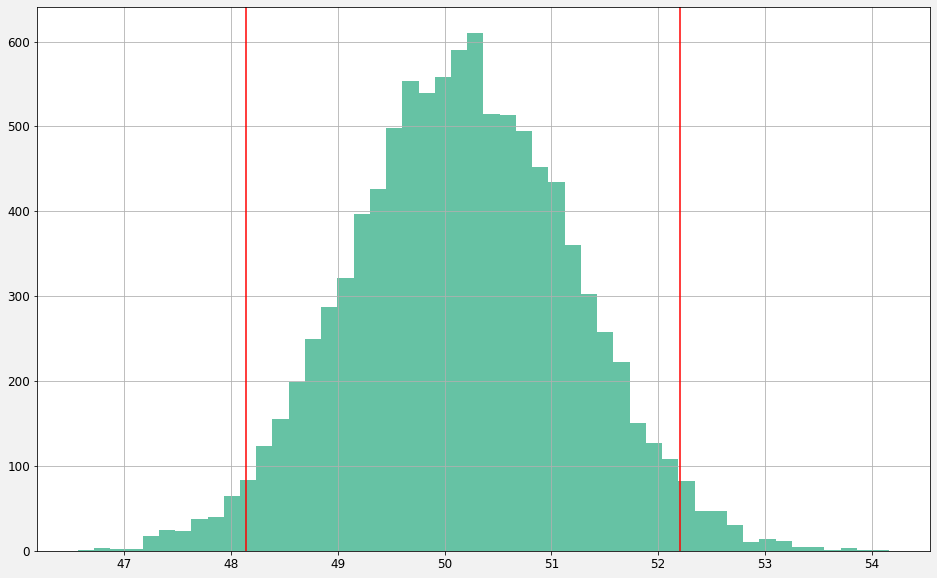

In [30]:
fig, ax =plt.subplots()
sampleMeans.hist(bins=50, ax=ax)
ax.axvline(CI_neg, color="red")
ax.axvline(CI_pos, color="red")


### Lazy statistician method

The simulation approach above is intuitive and flexible (and variants of such simulations are used extensively in statistics and we will make use simulation throughout this course to understand and check our modelling.) 

But for relatively simple cases where we want to find the standard error and confidence interval of an estimate (like a sample mean), statisticians take a short cut. They assume--here based on the Central Limit Theorem--that the distribution of the estimate will be normal. Then they use some math based on the mathematical form of the normal distribution to come to the following formula for the standard error of a sample mean: 

$$SE_{mean} = \frac{\sigma}{\sqrt(S)}$$

Where $\sigma$ is the "true" standard deviation (in our case 10) and S is the sample size (in our case 100). We could then calculate:

In [25]:
true_std/np.sqrt(S)

1.0

And we get an answer close to our simulation estimates for the standard error of the sample mean. 

Of course, in real life, we don't have access to the "true" standard deviation, and we would have to replace this with our sample standard deviation: 

$$\hat{SE_{mean}} = \frac{\hat{\sigma}}{\sqrt{S}}$$

The little triangular "hats" are meant to signify that the values are estimates in statistics. 

In [26]:
SE_hat = std_estimate/np.sqrt(S)
SE_hat

0.9828206502662047

We can then construct confidence intervals in the same way as above. An approximate 95 percent confidence interval would, for example be to take the estimated mean +/- 2 standard errors.

In [27]:
CI_neg = mean_estimate - 2*SE_hat
CI_pos = mean_estimate + 2*SE_hat
print("95% confidence interval ", CI_neg, CI_pos)

95% confidence interval  47.45399995310314 51.385282554167965


### Bootstrapping

<iframe src="https://ntnu.cloud.panopto.eu/Panopto/Pages/Embed.aspx?id=cb06e032-965d-4768-ad37-af02009e1223&autoplay=false&offerviewer=true&showtitle=true&showbrand=true&captions=false&interactivity=all" height="405" width="720" style="border: 1px solid #464646;" allowfullscreen allow="autoplay"></iframe>

Before going on to more complicated estimations, we want to discuss one more important form of uncertainty simulation: Bootstrapping. 

The term *bootstrapping* comes from the cowboy saying "Pull yourself up by the bootstrap", meaning you manage to accomplish something on your own with limited resources. The idea behind bootstrapping is to use the information in the limited sample you have collected to get a picture of the uncertainty of an estimate **without** relying on the assumption of a nice normal distribution (or other distributions for that matter). 

The key to bootstrapping is the idea of sampling with replacement. Starting with our initial sample of 100 observations, we demonstrate below:

In [31]:
boot = rGDP.sample(n=100, replace=True)

In [32]:
print(boot, rGDP)
print(boot.mean())

45    41.033418
61    48.691453
23    48.174958
44    53.555808
25    64.982874
        ...    
80    47.718038
24    42.482670
66    56.607026
35    64.412811
30    45.990167
Length: 100, dtype: float64 0     35.456746
1     62.836686
2     51.050662
3     39.436621
4     51.145072
        ...    
95    53.724537
96    50.319837
97    44.747270
98    69.812804
99    48.741603
Length: 100, dtype: float64
52.46203626509419


above we show one iteration of a bootstrap. We take the original sample, *rGDP* and then sample a 100 observations with replacement. So, we could visualize taking the original sample of 100 rGDP values, writing those values on 100 balls and putting them in an urn. Then we draw balls from the urn, one-by-one, noting the number and replacing the ball after we have recorded our number. 

Taking the mean of the resampled, or "bootstrapped" sample, we now have generated an alternative mean sample. Now if we do this say, 10,000 times, we can generate a distribution of the means and say something about uncertainty: 

In [33]:
N=10000

boots = []

for i in range(N):
    boot = rGDP.sample(n=100, replace=True)
    boots.append(boot.mean())

boots = pd.Series(boots)
    

<AxesSubplot:>

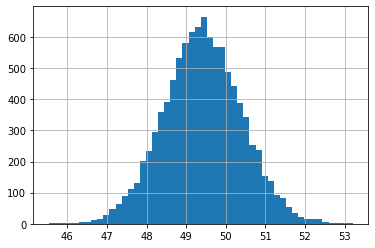

In [31]:
boots.hist(bins=50)


And we can estimate the standard error: 



In [331]:
SE_BS = boots.std()
SE_BS

0.9645023681545994

Using bootstrapping, we have managed to generate a distribution of our sample means. In this case we get a nice normal looking distribution, like we got when we (correctly) assumed normality. 

The cool thing about the bootstrap is that it will tend to give good approximations of the uncertainty of an estimate (assuming you design the bootsrap correctly) no matter the underlying distribution. This is why bootstrapping is often used to estimate standard errors in cases where you have complicated models.

In the above example, we probably get a slightly better answer both by using the "lazy" analytical method ($\hat{\sigma}/\sqrt{S}$) or by simulating with the assumption of normality, because we know that sample means are normal.

Bootstrapping also has limitations, as is discussed in ROS p.75.

### Uncertainty of other estimates

<iframe src="https://ntnu.cloud.panopto.eu/Panopto/Pages/Embed.aspx?id=86a7eec6-7ad5-4ea4-a37e-af02009e1223&autoplay=false&offerviewer=true&showtitle=true&showbrand=true&captions=false&interactivity=all" height="405" width="720" style="border: 1px solid #464646;" allowfullscreen allow="autoplay"></iframe>

We have spent a long time working through various ways of estimating the uncertainty around a sample mean. This is not because sample means are so important - they are not, we could have just used the "lazy" shortcut of getting the standard error by dividing by the square root of the sample standard deviation. 

The point has been to try to get an understanding of what we mean by uncertainty of an estimate and to give you some tools for generating uncertainty no matter what type of estimate you are looking at. 

Below we will look at other common sample estimates, and we will estimate the uncertainty of these estimates both through simulation and by simple mathematical formulas where they exist.

#### Proportion

Let's say that we have survey data of 1000 representative likely voters from October of 2016 where the question is: will you vote for Donald Trump in the election. 

Let's say that the true value for the population of voters is 49% will vote for Donald Trump (remember, in the weird US voting system, you can amazingly win without getting a majority of the votes). So let's model this as coming from a binomial distribution: 

In [34]:
p=.49
N=1000

voteTrump = np.random.binomial(N,p)

In [35]:
voteTrump

496

We can then estimate our sample **proportion** $\hat{p}$

In [36]:
p_hat = voteTrump/N
p_hat

0.496

We can again use some simulation to generate uncertainty: 

In [37]:
props = []

for i in range(10000):
    prop = np.random.binomial(N,p_hat)/N
    props.append(prop)

props = pd.Series(props)

<AxesSubplot:>

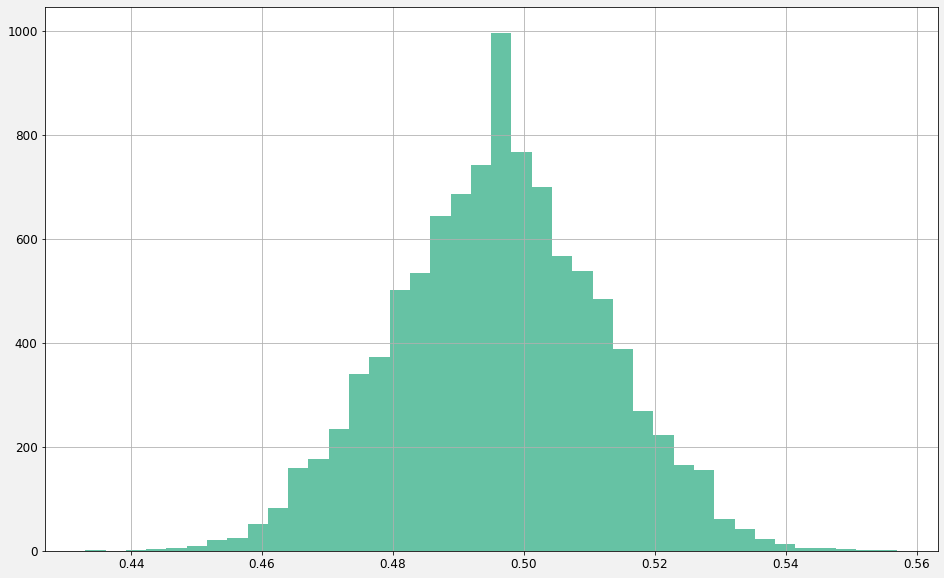

In [38]:
props.hist(bins=40)

Then we can estimate a **standard error**:

In [39]:
SE_prop = props.std()
SE_prop

0.01580520921892043

And create an 95% confidence interval

In [37]:
CI_neg = p_hat - 2*SE_prop
CI_pos = p_hat + 2*SE_prop
print("95% Confidence intervall", CI_neg, CI_pos)

95% Confidence intervall 0.45330677544003617 0.5166932245599638


#### Lazy shortcut 

For a proportion from a binomial distribution we can also make use of a simple formula for the standard error:SE =  $\sqrt{\hat{p}(1-\hat{p})/N}$

In [38]:
SE2_prop = np.sqrt(p_hat*(1-p_hat)/N)
SE2_prop

0.01580427157448264

In [39]:
CI_neg = p_hat - 2*SE2_prop
CI_pos = p_hat + 2*SE2_prop

In [40]:
print("95% Confidence intervall", CI_neg, CI_pos)

95% Confidence intervall 0.4533914568510347 0.5166085431489653


And we might also recall that with a large enough N, the normal distribution is a good proxy for the binomial distribution. 

### Standard error for a comparison

So far, what we have done hasn't been particularly useful. Estimating a mean or proportion in itself isn't usually that interesting. 

ROS (p.52) gives the example of trying to estimate the gender gap for voting. We can imagine that this is estimated by taking the difference between two independent surveys 400 men and 600 women. Using the numbers in the book, let's say that the *true* proportion of men is 57% who plan to vote for Donald Trump, while only 45% of women plan on voting for Donald Trump. We can simulate two sample proportions: 

In [41]:
p_male = .57
p_female = .45
N_male = 400
N_female = 600


p_male_hat = np.random.binomial(N_male, p_male)/N_male
p_female_hat = np.random.binomial(N_female, p_female)/N_female

diff_hat = p_male_hat-p_female_hat

print("sample male proportion", p_male_hat)
print("sample female proportion", p_female_hat)


sample male proportion 0.6025
sample female proportion 0.4683333333333333


If we then generate distributions for proportion (this time I will use a list-magic to create a for-loop): 

<AxesSubplot:>

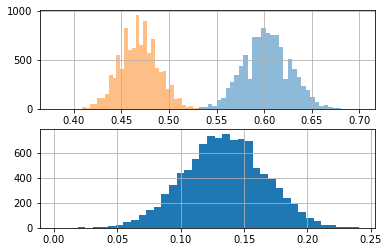

In [42]:
nsims = 10000

ps_male = []
ps_females = []

#Males
ps_male = pd.Series([np.random.binomial(N_male, p_male_hat)/N_male for i in range(nsims)])

#Females
ps_female = pd.Series([np.random.binomial(N_female, p_female_hat)/N_female for i in range(nsims)])

#Difference:
gender_gap = ps_male-ps_female

fig, ax = plt.subplots(2)
ps_male.hist(bins = 40, ax=ax[0], alpha=.5)
ps_female.hist(bins=40,  ax=ax[0], alpha=.5)
gender_gap.hist(bins=40, ax=ax[1])

Then we can calculate an estimate of the standard error of the difference:  

In [43]:
SE_diff = gender_gap.std()

CI_neg = diff_hat - 2*SE_diff
CI_pos = diff_hat + 2*SE_diff
print("SE of difference", SE_diff)
print("95% percent confidence intervall", CI_neg, CI_pos)

SE of difference 0.03185847654726326
95% percent confidence intervall 0.0704497135721402 0.19788361976119323


Or we can use a formula for the standard error of a difference, which is to take the square root of the sum of the squared standard errors: $SE_{diff} = \sqrt{SE_{males}^2 + SE_{females}^2}$

In [44]:
#Using our formulas for the standard errors for proportions

SE2_male = np.sqrt(p_male_hat*(1-p_male_hat)/N_male)
SE2_female = np.sqrt(p_female_hat*(1-p_female_hat)/N_male)

#and then our formula for the standard error of a difference
SE2_diff = np.sqrt(SE2_male**2 + SE2_female**2)
print("SE of difference", SE2_diff)

#confidence intervall
CI_low = diff_hat - 2*SE2_diff
CI_high = diff_hat + 2*SE2_diff
print("95% confidence intervall", CI_low, CI_high)

SE of difference 0.034946064593249344
95% confidence intervall 0.06427453748016802 0.2040587958531654


Here we see that there is quite a lot of uncertainty around what the actual gender gap. 

### Uncertainty about uncertainty: distribution of standard deviations and $\chi^2$ distribution

<iframe src="https://ntnu.cloud.panopto.eu/Panopto/Pages/Embed.aspx?id=86c3c13f-8d50-4eba-b5f4-af02009e1225&autoplay=false&offerviewer=true&showtitle=true&showbrand=true&captions=false&interactivity=all" height="405" width="720" style="border: 1px solid #464646;" allowfullscreen allow="autoplay"></iframe>

Let's step back for a bit. 

We've introduced the idea of a sample of say n draws from a normal distribution. We'll follow ROS and call these samples $y_1,...y_n$. To be concrete, let's say it is a sample of 10, from standard normal distribution (0 mean, 1 std)

In [45]:
true_mean = 0
true_std = 1

n=10
y = np.random.normal(true_mean,true_std,n)

We've talked extensively now about the sample mean $\hat{y}$: 

In [46]:
y.mean()

-0.18729226373908908

But sometimes we are equally interested in the spread of this random variable. For example, in finance we are often interested in estimating the spread (variance) of a series as a proxy for risk

Our formula for standard deviation is: $s_y = \sqrt{\frac{1}{n-1}\sum^n_{i=1}(y_i - \bar{y})^2}$

In [47]:
y_bar = y.mean()

In [48]:
s_y = np.sqrt(1/(n-1)*np.sum((y-y.mean())**2))
s_y

0.7005942107154018

Which is the same as the following:

In [49]:
y.std(ddof=1)

0.7005942107154018

Let's create a distribution around the estimate. We'll start by creating our own sample standard deviation formula:

In [50]:
def sstd(y):
    return(np.sqrt(1/(n-1)*np.sum((y-y.mean())**2)))


In [51]:
nSims = 10000

sstd_dist = pd.Series([sstd(np.random.normal(y_bar, s_y, n)) for i in range(nSims)])

<AxesSubplot:>

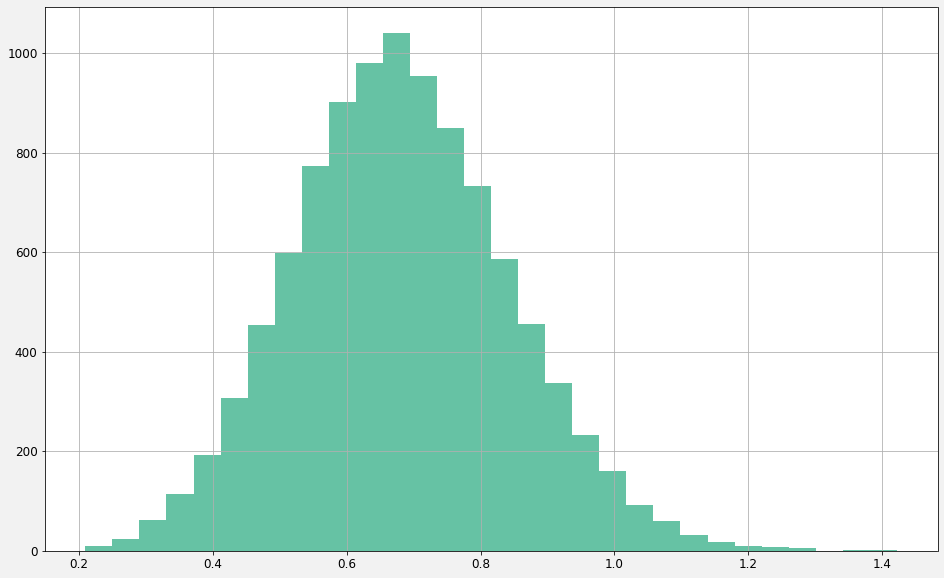

In [52]:
sstd_dist.hist(bins=30)

The above distribution doesn't look quite normal. It seems to have more weight on the right side. 

If we do the following transformation: $\frac{s_y^2*(n-1)}{\sigma^2}$, where we recall that $\sigma^2$ is the "true" variance, then the observations will be distributed by what is called a $\chi^2$ ("Chi-squared") distribution with n-1 degrees of freedom: 

<AxesSubplot:>

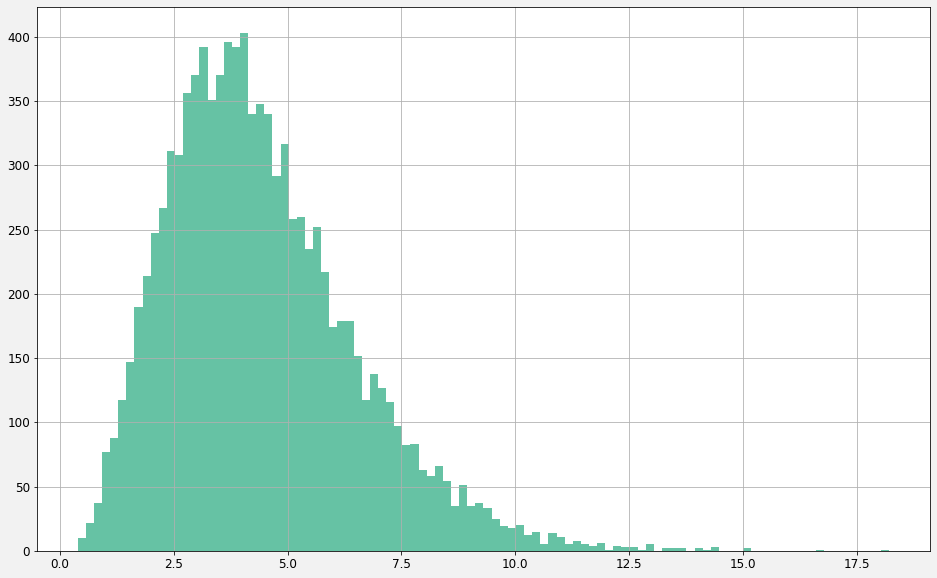

In [53]:
tr_sstd_dist = sstd_dist**2*(n-1)/(true_std**2)
tr_sstd_dist.hist(bins=100)



We can generate random draws from a chi-squared distribution with numpy: 



<AxesSubplot:>

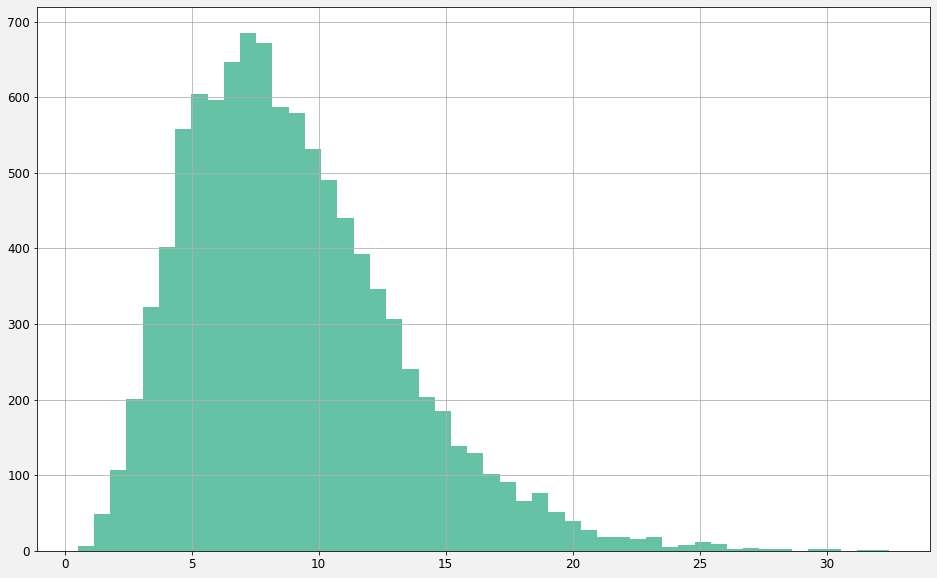

In [54]:
df = n-1 # degrees of freedom

chisqDraws = pd.Series(np.random.chisquare(df, 10000))
chisqDraws.hist(bins=50)

Now that we have generated simulated values from the Chi-Squared distribution, we could go on to construct standard errors and confidence intervals for the standard deviation as well. 

### What is this "degrees of freedom stuff?"

In specifying the correct chi-squared distribution, we used the concept of "degrees of freedom". We will see this concept used more as we move into regression modelling. ROS explains that the concept is used to avoid "overfitting" of data. 

Let's try to add a little bit of intuition. 

Let's say we have one observation, to be concrete x=5. Can you calculate the mean of this observation. 

Obviously, the mean is x=5. 

Can we calculate the standard deviation? No! Because to calculate the standard deviation we need to first calculate the sample mean (see the formula above), but then we have run out of observations. 

To calculate a sample standard deviation we need at least 2 observations, giving us n-1 => 2-1 = 1 degree of freedom.  

### Fat tails and t-distribution

The normal distribution has what we call "thin" tails - that is if we were to look at a histogram of the number of observations, the left and right tails quickly becomes very small.

But if we have a small sample, say n=5, these "thin" tails can become a problem when we are trying to calculate the uncertainty of an estimate (a sample mean for example). 

With small samples, there is more uncertainty then the normal distribution takes into account. This is why we use the *t-distribution* in such cases. 

In [68]:
n= 5
mySample = np.random.normal(30,10, n)

In [139]:
s_mu = mySample.mean() #sample mean
SE = mySample.std(ddof=1)/np.sqrt(n)

#remember spt == scipy.stats
t_025 = spt.t(df=n-1).ppf(.975)

t_025

2.7764451051977987

Recall, that if we want a 95% confidence interval for a normal distribution, we can multiply 2 by the standard error (approximately). Above, we see that for the t-distribution this multiplier is larger. 

In [70]:
CI_low = s_mu - SE*t_025
CI_high = s_mu + SE*t_025

print("Small-sample mean confidence intervall:", CI_low, CI_high)

Small-sample mean confidence intervall: 23.82910780243845 40.18867683510799


As soon as the number of observations in a sample increases, we can go back to using the normal approximation (see exercise below). 

### Bias

Let's go back to looking at the formula for sample standard deviations: 

$s_y = \sqrt{\frac{1}{n-1}\sum^n_{i=1}(y_i - \bar{y})^2}$

why do we multiply by $\frac{1}{n-1}$ rather than the more intuitive $\frac{1}{n}$

Let's try to understand by simulating. 

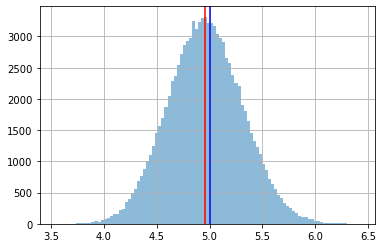

In [72]:
true_mean = 10
true_sd = 5
n=100

#we'll generate a sample 100,000 times and take the sample standard deviation **without** the n-1 adjustment
nsim=100000

sstds = pd.Series([np.random.normal(true_mean, true_sd, n).std() for i in range(nsim)])

simMeanSD = sstds.mean()

fig, ax = plt.subplots()
sstds.hist(bins=100, alpha=.5)
ax.axvline(x=simMeanSD, color="red")
ax.axvline(x=true_sd, color="blue")





Above we have simulated 100,000 sample standard deviations. 

The blue line represents the "true" standard deviation from the actual normal distribution we were drawing from.

The red line represents the mean of the simulated sample standard deviations. Notice how there is a gap between the mean of the simulated distribution and the actual standard deviation. This gap is what we call **statistical bias**. We have a sample estimate of the "true" standard deviation that *on average* is not equal to the value we are trying to estimate. 

Even if we increase the number of simulations - one million, one billion, there will still be a gap. 

We don't want biased estimators. We want estimators that, if in theory we could sample many times, the average of the estimates would get close to the "true" value we are trying to estimate. 

So let's try again, this time using our adjusted formula for calculating a sample standard deviation (multiply by $\frac{1}{n-1}$

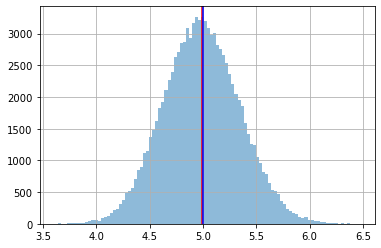

In [73]:
nsim=100000

sstds = pd.Series([np.random.normal(true_mean, true_sd, n).std(ddof=1) for i in range(nsim)])

simMeanSD = sstds.mean()

fig, ax = plt.subplots()
sstds.hist(bins=100, alpha=.5)
ax.axvline(x=simMeanSD, color="red")
ax.axvline(x=true_sd, color="blue")




## Hypothesis testing, p-value and statistical significance

Formal hypothesis testing is not a prime focus of this course. ROS (p.57-67) has a good discussion of the problematic sides of statistical significance and hypothesis testing more general. In this course we have a more direct focus on estimation of statistics and then calculating measures of the uncertainty of those estimates. 

But still, hypothesis testing is everywhere, and it will pop up in the course from time to time, so below we work through a hypothesis testing example, reviewing some of the concepts you probably have exposed to from before. 

Let's consider a randomized control trial, and we'll take inspiration from [this study](https://www.nature.com/articles/ejcn201392) on the effects of a whole-foods low-fat plant-based diet on body weight (and other health metrics) among a sample of office workers who were overweight and/or type II diabetes. 

In this study, the investigators worked together with an insurance company to design an experiment. Employees at the insurance company who volunteered for the study were **randomly** placed either in a *intervention* (sometimes called *treatment*) group, where they were to follow a low-fat plant-based diet and went to weekly support groups and where the work cafeteria options for healthy nutrition were available. 

The control group were simply to maintain their normal lifestyle. 

The study lasted for 18 months, after which several measures of health were recorded. We will just consider weight.

(One note on research design: In a perfect medical intervention design, both the intervention group and the control group do not know which group they are in. For a medicine, this might mean that the control group gets a sugar pill every day, instead of the actual medicine.  The reason this is important is the well documented and sometimes large effects of placebo. This is nearly impossible in studies on nutrition. If you think you are taking a medicine, or doing something good for yourself, that in itself may have actual physical effects. )


## Hypothesis: 

In hypothesis testing, we of course start with a **null** hypothesis and an **alternative** hypothesis. The null hypothesis is often the conservative hypothesis we might like to show evidence against. So here: 

**Null hypothesis**: Changing to a low-fat plant-based diet has no effect on weight

**Alternative hypothesis (one sided)**: Changing to a low-fat plant-based diet leads to weight loss. 





Our *parameter of interest*, $\theta$ is then the difference in weight loss between treatment ($\theta_T$) and controll group ($\theta_C$):  $\theta = \theta_T - \theta_C\$

We don't have access to the actual data, so let's simulate some data. Let's say that the "true" or population distribution for people in the the control group is normally distributed with mean $\theta_T = -4.3kg$ (this was in fact the mean change observed in the actual study among the control group.), and standard deviation of 12 ($\sigma_T=12$) 

And let us assume that the true change in weight among the control group was 0: ($\theta_C = 0$), with a standard deviation 7 ($\sigma_C=7$). 

(So we could imagine that the above distribution represents all people, or all people in the US, or whatever population you are interested in). 

We have $n_T = 200$ participants in the treatment group.

We have $n_C = 200$ participants in the control group. 

We simulate: 

In [2]:
theta_T = -4.3
theta_C = 0
sigma_T = 14
sigma_C = 7

n = 200


ys_T = np.random.normal(theta_T, sigma_T, n)
ys_C = np.random.normal(theta_C, sigma_C, n)

Then we estimate sample means and sample standard deviations

In [3]:
y_T_bar = ys_T.mean()
std_T = ys_T.std(ddof=1)
y_C_bar = ys_C.mean()
std_C = ys_C.std(ddof=1)

print(y_T_bar, std_T, y_C_bar, std_C)

-4.183192458523267 14.311124718870769 -0.6353534186839961 7.198625253499269


The estimate we are interested in is $\hat{\theta} = \bar{y_T} - \bar{y_C}$



In [4]:
theta_hat = y_T_bar - y_C_bar
theta_hat

-3.547839039839271

And since we are taking the difference of two sample means, the standard error is calculated: 

In [5]:
SE_theta = np.sqrt(std_T**2/(n) + std_C**2/(n))

In [6]:
SE_theta

1.1327587921958304

(Notice, we could also have done the above calculation through simulation if we wanted to.)

So now we are ready to calculate our confidence interval. Since we have n=200 observations in our sample of both treatment and control, then it will probably be fine to assume that using the normal distribution will be a good approximation to the distribution of the estimate (rather than using the t-distribution). We can then add +/- 2*SE to our mean: 

In [7]:
CI_low = theta_hat - 2*SE_theta
CI_high =theta_hat + 2*SE_theta

print("95% Confidence interval", CI_low, CI_high)

95% Confidence interval -5.8133566242309325 -1.2823214554476103


A traditional ("frequentist") way of interpreting this confidence interval would be to say that 95% percent of the time that such a experiment is run, we would expect to see a weight decrease of switching to a plant based diet of between -3.5 to -8.2. 

### Statistical significance

Notably, the confidence interval does not include 0, and thus we can say that we **reject** the null hypothesis (of 0 change in weight) at the 5% level. 

Another way of saying this is that our estimated effect is **statistically significant** at the 5% level. 

### p-value

To understand what the p-value is, it can be helpful to simulate a distribution **assuming that our null hypothesis is true**, that is that $\theta=0$

In [13]:
nsims=100000
null_dist = pd.Series(np.random.normal(0, SE_theta, nsims))

(-7.0, 7.0)

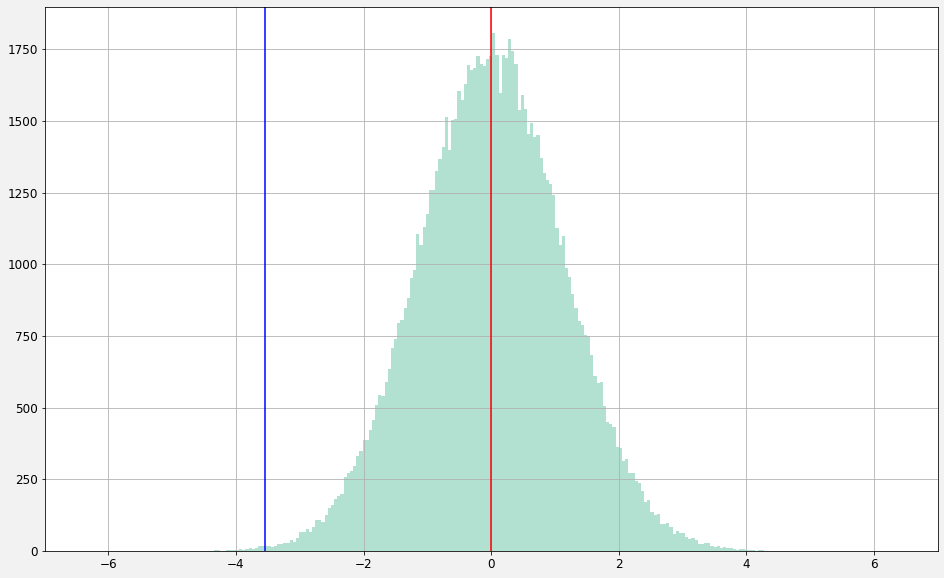

In [14]:
fig, ax = plt.subplots()
null_dist.hist(bins=200, alpha=.5, ax=ax)
ax.axvline(x=0, color="red")
ax.axvline(x=theta_hat, color="blue")
ax.set_xlim(-7,7)



The red line is our null hypothesis of 0 change, and the blue line is our actual test statistic. What is the chance, according to our simulated distribution that we get a test statistic equal or greater than our actual test statistic **by pure chance, assuming the null hypothesis is true**?

We can calculate this out: 

In [15]:
null_dist[null_dist<theta_hat].count()/nsims

0.0009

This number is our p-value. If we were interested in a two-sided test, we would double the value to take into account a weight **gain** of corresponding value as well by pure chance. 

If we are using a 5% significance level, as long as the p-value<.05, then we would say our test statistic is significant. 

We can also calculate our p-value in Python without simulating using the cumulative distribution function from scipy.stats: 

In [16]:
spt.norm(0,SE_theta).cdf(theta_hat)

0.0008679988798651466

The CDF function adds up all the combined probability up to the given value (here theta_hat)

# Exercises

## 1. Simulating uncertainty of sample means

Say that we want to estimate the mean height of female business students in Norway. We gather a sample of 100 students and find that the sample mean is 160cm and the standard deviation of our sample is 10. 

a. Using a simulation with 10.000 runs, generate a distribution of the sample means. Show a histogram of the distribution of sample means and calculate the the standard error (the standard deviation of the distribution of sample means). Calculate a 95% confidence interval for the sample means. How does this compare to the analytic solution ($SE_{mean} = \frac{\sigma}{\sqrt(S)}$)

b. Now we also gather 100 male business students in Norway and measure their height. We get a sample mean of 178 and a standard deviation of 12. Simulate a distribution for the difference in sample means between males and females and calculate the standard error. 

## 2. Confidence intervals using normal and t-distributions

Generate a small sample of 5 random values from a normal distribution with mean $\mu=30$ and standard deviation $\sigma=5$.

a. Calculate the mean of the sample, and then calculate estimated 95% confidence intervals for the sample mean based on the normal and t-distribution (HINT: You can use the function sts.t.interval(), and sts.norm.intervall() to automatically create intervals given a sample mean and standard error of the sample mean.)


b. Now run a simulation (with, say 10.000 simulations). Within each simulation, create a random sample with n=5, calculate confidence intervals with both normal and t-distribution and then test whether these intervals contains the *true* sample mean. Save this result (either as a *True/False* value or *1/0* value). In what percentage of the simulations do the confidence intervals include the true value for the normal and t approximations?

c. Do the same steps above when the sample size is n=30

# 3. Hypothesis testing, p-values and Cochrane reports

One of the best tools for understanding and interpreting the available scientific information on medicine and health are the [Cochrane Reports](https://www.cochrane.org/). This non-profit group looks through the literature on medical and health studies and tries to summarize the available evidence on a certain topic,  making use of robust statistical methodologies. 

Let's consider the [available evidence for exercise as treatment for coronary heart disease](https://www.cochrane.org/CD001800/VASC_exercise-based-rehabilitation-coronary-heart-disease).

a. Read the report linked to above. In the main results, how does Cochrane report the results? What statistical concepts do they use? What type of language is used to report results? Are the effects big or small?

Now let's consider one particular study that comes from NTNU's own [Cardiac Exercise Research Group (CERG)](https://www.ntnu.edu/cerg). This study wanted to test to see if [intervall training reduces plaque in heart patients](https://www.ntnu.edu/cerg/publications#9-22). They chose 60 participants who had recently been treated for coronary heart disease and split the group into a treatment group (30 participants) and controll group (30 participants), where the treatment group performed high-intensity interval training twice weekly for 6 months under supervision. The control group were instructed to carry on as before with general exercise advice. Of the initial treatment group n=20 stayed in the program for the full 6 months, and n=29 of the control group were followed up. 


From [table 2 of the research article](https://www.ahajournals.org/doi/full/10.1161/JAHA.121.024705) For the treatment group, a measure of artery plaque before the exercise program began reported a mean score of 357 with a standard deviation of 136. After 6 months the same group had a mean value of 306 with a standard deviation of 150. 

b. Calculate the difference in means between before ("baseline") and after ("Follow-up") and provide a standard error of the estimate. Create a 95% confidence interval (I recommend using simulation to estimate the standard error and confidence interval).

c. If the null hypothesis is that exercise had no effect, what is the p-value of the result? Interpret the p-value.

d. Under a hypothesis testing frameworks, we usually set a significance level at 5%. Would we reject the null hypothesis under this significance level. In this case, would we reject the null-hypothesis. Discuss the problems of hypothesis testing and p-values in relation to this study. 


# 4. Choose your own study

Go to the [Cochrane Reports](https://www.cochrane.org) and find a medical or health question you are interested in. 

a. Give a short (3-5 sentences) summary of the evidence. 

b. Find a specific study with a treatment and control group. Most quality papers will include a table with means and standard deviations of the groups. Based on this information construct a test statistic of interest (difference in means for example) with an appropriate standard error (I recommend using simulation to estimate the standard error). Calculate a 95% confidence interval and a p-value. Interpret the results.
